# A practical introduction to ACRA

FOM Seminars, by D. Rios, V. Gallego, R. Naveiro.


* More info at https://github.com/roinaveiro/ACRA_spam_experiment

In [1]:
import pandas as pd
import numpy as np
from acra_tools import *
import time
from joblib import Parallel, delayed
import multiprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(3215)

Ilustraremos el marco ACRA utilizando un ejemplo sencillo de detección de SPAM. Primero leemos el dataset

In [2]:
data = pd.read_csv("data/uciData.csv")
data.head()

,word_make,word_address,word_all,word_3d,word_our,word_over,word_remove,word_internet,word_order,word_mail,...,word_edu,word_table,word_conference,char_,char_(,char_[,char_!,char_$,char_#,spam
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,1,0,1,1,1,1
2,1,0,1,0,1,1,1,1,1,1,...,1,0,0,1,1,0,1,1,1,1
3,0,0,0,0,1,0,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,1,0,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1


Los mails se representan utilizando *bag-of-words*, es decir; un uno indica que la palabra/caracter correspondiente está presente, y un cero que está ausente.

Creamos conjunto de train y test.

In [3]:
X = data.drop("spam", axis=1).values
y = data.spam.values
q = 0.10   #Porcentaje de datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=q)

Utilizaremos como clasificador base Naïve-Bayes

<img src="nb.png">

In [4]:
clf = trainRawNB(X_train, y_train) 

Como trabajamos con **Utility-Sensitive Naïve Bayes**, necesitamos una matriz de utilidades

In [5]:
ut = np.array([[1,-1],[-5,1]])
ut

array([[ 1, -1],
       [-5,  1]])

La utilidad de clasificar un email legítimo como spam tiene que ser muy negativa, ya que no es deseable! Veamos qué tal lo hace Naïve-Bayes **datos limpios**.

In [6]:
y_pred = nbusXlabel(X_test, clf, ut) # devuelve la etiqueta dada una matriz de utilidad
print( "Matriz de confusión: \n ", confusion_matrix(y_test, y_pred))
print( "Precisión", accuracy_score(y_test, y_pred))

Matriz de confusión: 
  [[259  16]
 [ 42 144]]
Precisión 0.8741865509761388


Con muy poco esfuerzo, conseguimos un clasificador decente. Pero veamos si es robusto frente ataques adversarios. Nos vamos a restringir a ataques muy sencillos. Consisten tan solo en añadir una palabra *buena*. Veremos que estos ataques tan sencillos son enormemente dañinos. Esta función implementa un ataque, resolviendo el problema del atacante, maximizando su utilidad. El atacante solo puede cambiar los emails que son spam

In [7]:
X_test_atacked = sc_attack(X_test, y_test, clf, n = 1) ## n=1 indica que se inserta una palabra buena

In [10]:
y_pred_attacked = nbusXlabel(X_test_atacked, clf, ut) # devuelve la etiqueta dada una matriz de utilidad
print( "Matriz de confusión: \n ", confusion_matrix(y_test, y_pred_attacked))
print( "Precisión", accuracy_score(y_test, y_pred_attacked))

Matriz de confusión: 
  [[259  16]
 [167  19]]
Precisión 0.6030368763557483


Vemos que la precisión disminuye enormemente! Como podemos apreciar, tan solo añadiendo una palabra buena, el atacante consigue que muchos emails spam, sean clasificados como legítimos. Estos ataques se denomina **ataques de violación de integridad**

In [11]:
aux = X_test_atacked[y_pred != y_pred_attacked] - X_test[y_pred != y_pred_attacked]
mode = np.argmax( np.bincount( np.where(aux[:,:] == 1)[1] ) )
data.columns[mode]

'word_fundacion_ortega_marañon\n'

En efecto, la proporción de emails spam en los que aparece **Fundación Ortega Marañón** es minima! Es decir, fundación ortega marañón es una palabra buena. No espereis recibir spam de la FOM...

In [12]:
len(data[(data.spam == 1) & (data[data.columns[mode]] == 1) ]) / len(data[data.spam == 0])

0.0003586800573888092

Veamos cóm se defiende ACRA frente a este ataque. Primero definimos unos parámetros de interés

In [13]:
var = 0.1 # variance parameter
m = 0.01 # mc size
n = 1 # tamaño ataques

In [14]:
tic = time.time()
result = getParResults(y_test, X_test_atacked, clf, ut, var, n, m)
y_ACRA = result[:,2]


In [15]:
print( "Matriz de confusión: \n ", confusion_matrix(y_test, y_ACRA))
print( "Precisión", accuracy_score(y_test, y_ACRA))

Matriz de confusión: 
  [[273   2]
 [ 41 145]]
Precisión 0.9067245119305857


ACRA recupera es robusto frente a estos ataques. Es más, consigue operar mejor que NaÏve Bayes sobre datos limpios. Este efecto tiene que ver con las defensas contra ejemplos adversarios actúan como regularizadores. Efecto también observado en Goodfellow(2014)

Explaining and Harnessing Adversarial Examples
Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy
https://arxiv.org/abs/1412.6572

Veamos cómo son las predicciones de ACRA sobre las acciones del enemigo. Escogemos un mail, y vemos cuál es la palabra que decide añadir el adversario.

In [16]:
Xp =  X_test[y_test == 1][5]
print("Palabra añadida: ", data.columns[np.where(Xp != sc_attackit(Xp, 1, clf, n))[0]][0] )

Palabra añadida:  word_fundacion_ortega_marañon



Calculamos la distribución de probabilidad, de acuerdo con el clasificador, sobre la palabra añadida y la representamos gráficamente

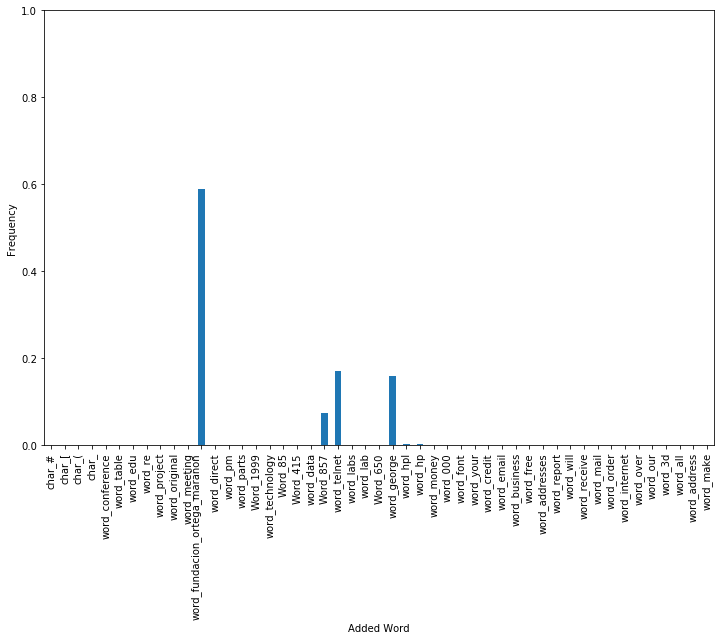

In [17]:
K = 1000 #número de muestras MC
var = 10**(-2)
dist = getporbs(Xp, Xp, clf, 0.01, n, K )

frequencies = dist[1][1:]/K
freq_series = pd.Series.from_array(frequencies)

x_labels = data.columns[np.where(Xp != dist[0][:])[1]]

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xlabel('Added Word')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.ylim(0,1)
rects = ax.patches

# Make some labels.
labels = ["label%d" % i for i in range(len(rects))]


    
plt.show()

Si disminuimos el grado de conocimiento que el clasificador tiene sobre el adversario, tendremos más incertidumbre acerca de sus movimientos.

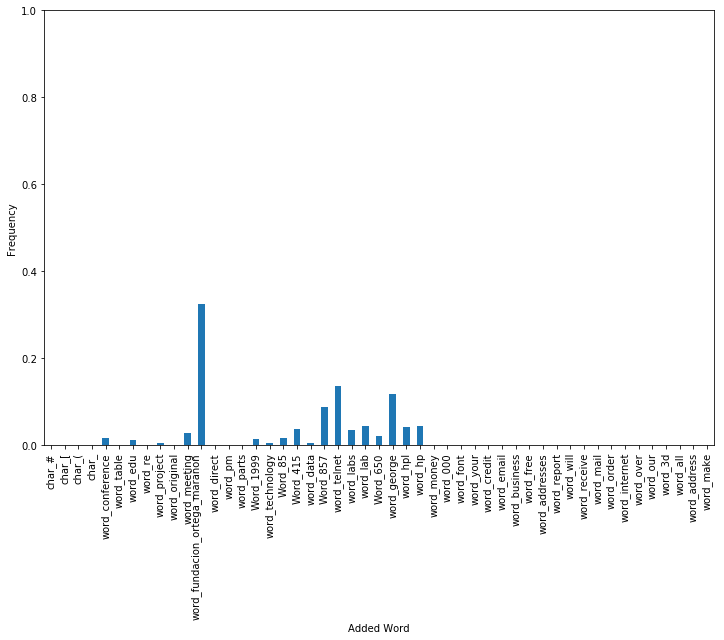

In [18]:
K = 1000 #número de muestras MC
var = 1-10**(-5)
dist = getporbs(Xp, Xp, clf, 0.99999999, n, K )

frequencies = dist[1][1:]/K
freq_series = pd.Series.from_array(frequencies)

x_labels = data.columns[np.where(Xp != dist[0][:])[1]]

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xlabel('Added Word')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)

plt.ylim(0,1)
rects = ax.patches

# Make some labels.
labels = ["label%d" % i for i in range(len(rects))]


    
plt.show()